# ML para predecir el gesto

Creación y evaluación de modelos de Machine Learning para predecir qué gesto está realizando el paciente

In [1]:
# ---------- importar librerías---------
# Manipular los datos
import pandas as pd
import numpy as np

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

# scikit-learn (ML en python)
## Procesar el dataset
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import LeaveOneGroupOut
## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
## Evaluación de los modelos
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, LearningCurveDisplay
## Hiperparametrizacion
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

## Seleccion de variables
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import RFECV # recursive

# Para ignorar los FutureWarning
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
#---------Importar los datos-----------
# Dataframe medidas calculadas por repetición
df = pd.read_csv('../csvFiles/medidasPerRepetition.csv', dtype=object) # salida de leer_dataset.ipynb
df.head() # visualizacion de la cabecera

,SubjectID,GestureLabel,RepetitionNumber,CorrectLabel,Position,Duration,HipAngleLeft_standardDeviation,RightArmAngle_standardDeviation,KneeAngleLeft_standardDeviation,AnkleAngleLeft_standardDeviation,...,ElbowAngleRight_Kurtosis,LeftArmAngle_Kurtosis,ShoulderAngleRight_Kurtosis,WristAngleLeft_Kurtosis,ElbowAngleLeft_Kurtosis,WristAngleRight_Kurtosis,ShoulderAngleLeft_Kurtosis,HipAngleRight_Kurtosis,ArmsTogetherAngle_Kurtosis,AnkleAngleRight_Kurtosis
0,101,0,1,1,stand,59,0.3608677355979031,2.7655574767746303,0.20870629032593843,0.6581472034160547,...,-1.5096047609935206,0.5374402120462101,0.24725567691914474,-1.1548519667455222,-0.9176895137907444,0.19853266525825441,-0.6351422949522179,-0.9240468871850966,-0.6043028159859238,-0.40440680981149635
1,101,0,2,1,stand,44,0.11857848631771781,2.2982802008603884,0.22148909073910306,0.8313514219454735,...,-1.280617105642371,0.7268055218978855,-1.7517830977424425,-0.7701703570143632,0.4187723636318532,1.0481449056142007,-0.9030033089456406,-0.19860783889835965,0.8934212147732565,-0.276497605679932
2,101,0,3,1,stand,53,0.24619052972163322,3.445303563459787,0.20016295285928792,0.9602665690153961,...,-1.4552465068519256,0.1405061114156383,0.7198891878500557,-0.5806536048592652,-0.76127983523148,-0.3931234568509234,0.412760624339358,-1.007601590228747,-0.4138693928861996,-0.5305323879118911
3,101,0,4,1,stand,57,0.28321350295077613,3.626021938955907,0.3449046585971368,0.5731684465708434,...,-1.51459552588099,1.0602340465863236,0.4958653590427531,-0.13640312363512264,-0.5844906010216535,-0.6109341257432597,-1.3306916169093075,-1.4875437672995169,-1.2588076707533085,-0.057357413926721
4,101,0,5,1,stand,60,0.39363598833851376,3.767306517718122,0.2176579492233252,0.6589984240898876,...,-1.3601464899179059,-1.527706279445947,0.39390720825161907,-0.42688443195923,-0.5349520236928611,-1.1701446029912246,-0.8445014311637222,-1.4273439546363045,-0.33874666284848587,-0.32227339359147944


In [3]:
test_result = pd.DataFrame({'Clasificadores': ['K-Neighbors',
                                            'Decision tree',
                                            'Naive Bayes',
                                            'Suport Vector Machine',
                                            'Random Forest']})


## 1. Preprocesado

### 1.1 Codificar variables

In [4]:
# ------Preparar el dataset-------
encoder = OrdinalEncoder(categories=[list(set(df["Position"].values))])
encoder.fit(df[["Position"]])
df["Position"] = encoder.transform(df[["Position"]])

# pasar variable obj to numeric
df = df.apply(pd.to_numeric, errors='ignore')

### 1.2 Dividir el dataset

In [5]:
# dejar dos pacientes como test

test_df = df.loc[(df.SubjectID==101) | (df.SubjectID==105) | (df.SubjectID==201) | (df.SubjectID==202) | (df.SubjectID==301) | (df.SubjectID==302)]
train_df = df.loc[(df.SubjectID!=101) & (df.SubjectID!=105) & (df.SubjectID!=201) & (df.SubjectID!=202) & (df.SubjectID!=301) & (df.SubjectID!=302)] 

train_X = train_df.drop(['GestureLabel'], axis=1)
train_y=pd.DataFrame(train_df['GestureLabel']) 
test_X= test_df.drop(['GestureLabel'], axis=1) 
test_y =pd.DataFrame(test_df['GestureLabel'])

# # Convertimos los df de target (y) a 1-d
train_y = train_y.values.ravel()
test_y = test_y.values.ravel()

## 2. Modelos de ML
Se ha creado una función para entrenar y evaluar los modelos

In [6]:
#-------Funcion para evaluar los modelos-----------
def test_models(modelos, tX, ty, df, column_name):
   new_evaluation = []
   for modelo in modelos:
      prediction = modelo.predict(tX) #  predicciones en los datos de prueba
      report = classification_report(ty, prediction, zero_division=0) # informe de evaluación
      score = f1_score(test_y, prediction, average='weighted', zero_division=0) 
      new_evaluation.append(score)
      print(f"\nModelo: {modelo.__class__.__name__}") 
      print(report) 
   df.loc[:, column_name] = new_evaluation

In [7]:
#-----------Función matriz de confusión-----
def plot_confusion_matrix(modelo, tX, ty):
    """
    Grafica la matriz de confusión para un modelo dado.

    Parámetros:
    * modelo: El modelo de clasificación entrenado.
    * tX: Los datos de prueba.
    * ty: Los valores reales del target para los datos de prueba.
    """

    prediction = modelo.predict(tX)
    cm = confusion_matrix(ty, prediction)
    ax = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    ax.set_title('Matriz de confusión ' + modelo.__class__.__name__)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

In [8]:
knn = KNeighborsClassifier() # K-Neighbors classifier
dtree = DecisionTreeClassifier() # Decision tree
nb = GaussianNB() # Naive Bayes
svm = SVC() # Suport Vector Machine
rf = RandomForestClassifier()  # Random Forest

models = [knn, dtree, nb, svm, rf]

for modelo in models:
    modelo.fit(train_X, train_y) # entrenamos el modelo

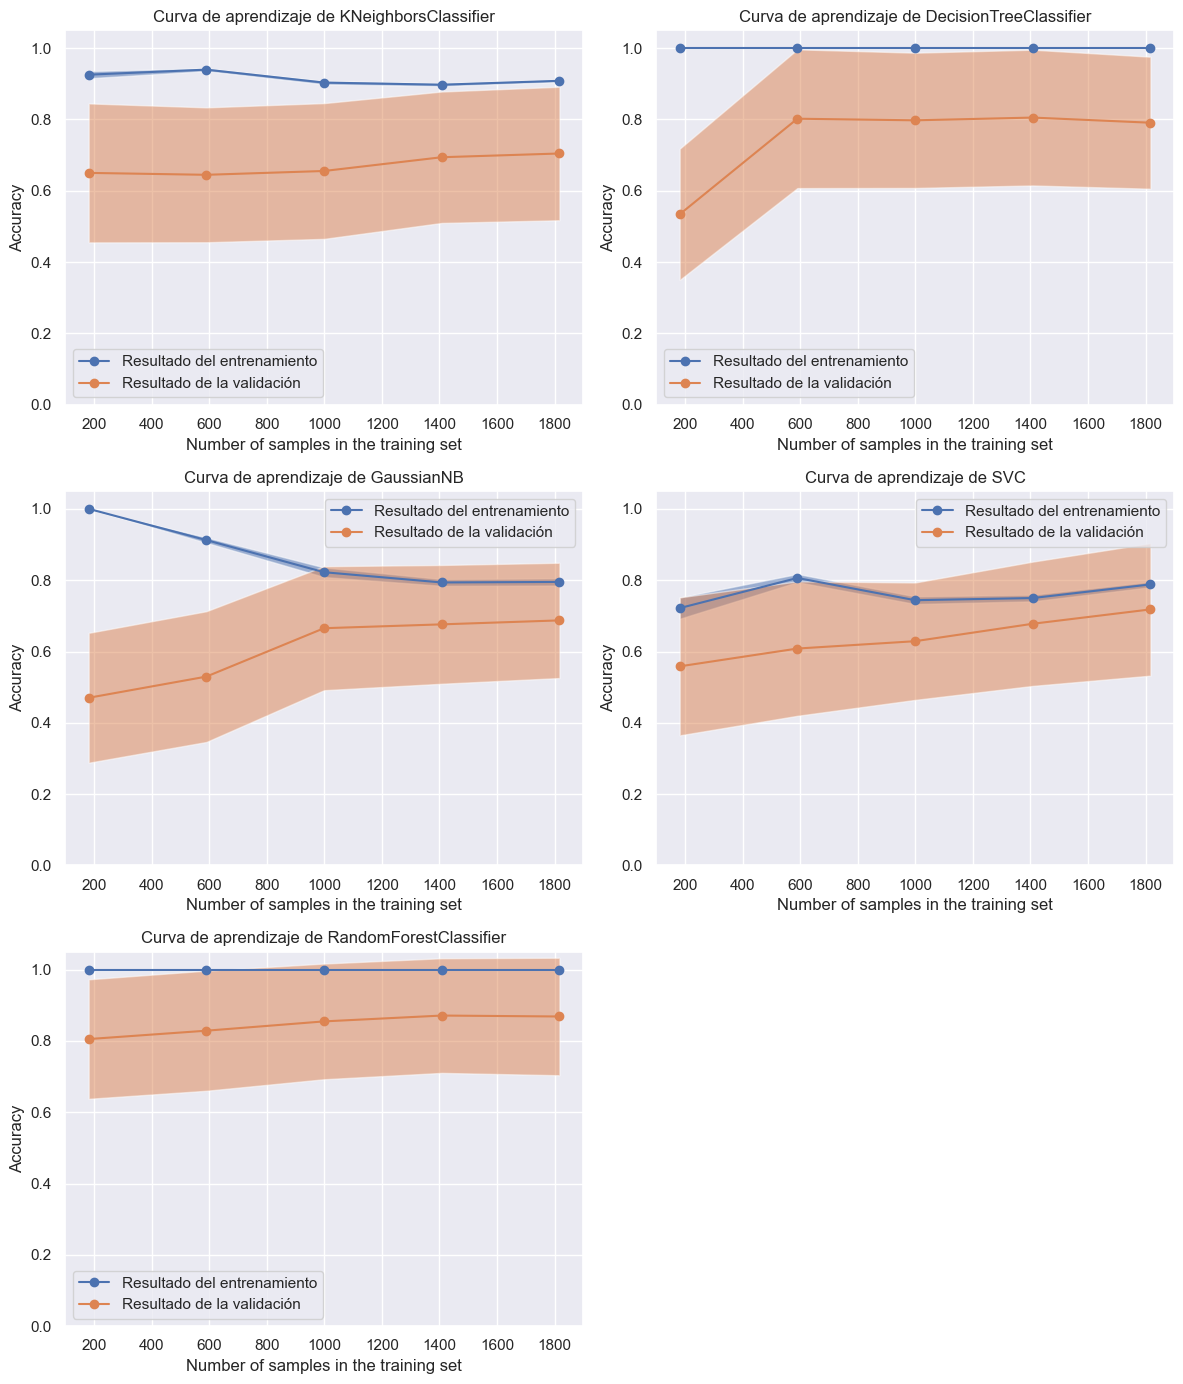

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))

common_params = {
    "X": train_X,
    "y": train_y,
    "groups": train_X['SubjectID'],
    # "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": LeaveOneGroupOut(),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}
for idx, estimator in enumerate(models):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Resultado del entrenamiento", "Resultado de la validación"])
    ax.set_title(f"Curva de aprendizaje de {estimator.__class__.__name__}")
    ax.set_ylim(0, 1.05)
fig.delaxes(axes.flatten()[5])

plt.tight_layout()
plt.show()

In [10]:
# entrenamiento + evaluación
test_models(models, test_X, test_y, test_result, 'Modelos')


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.72      0.90      0.80        58
           1       0.75      0.85      0.79        66
           2       0.58      0.64      0.61        95
           3       0.63      0.64      0.63        69
           4       0.77      0.36      0.49        94
           5       0.51      0.60      0.55        55
           6       0.94      0.86      0.90        58
           7       0.74      0.69      0.71        72
           8       0.74      0.85      0.79        95

    accuracy                           0.70       662
   macro avg       0.71      0.71      0.70       662
weighted avg       0.71      0.70      0.69       662


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        58
           1       0.92      0.74      0.82        66
           2       0.73      0.57      0.64        95
           3    

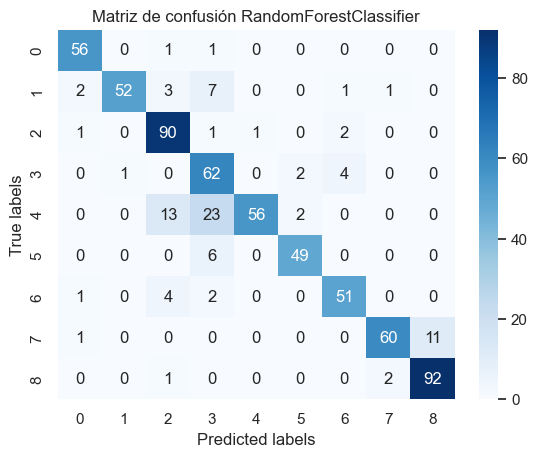

In [11]:
plot_confusion_matrix(rf, test_X, test_y)

## 3. Hipermetrización

In [12]:
#-------------Parametros---------------
param_grid_knn = {
    'n_neighbors': [6, 7, 8],
    'weights': ('uniform', 'distance'),
    'leaf_size': (3, 4, 5, 6, 8),
    'p': (1,2),
    'metric': ('minkowski', 'chebyshev')
}

param_grid_dtree = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 40, 50, 60],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 2, 5, 7],
    'max_features': [None, 'sqrt', 'log2']
}

param_grid_nb = {'var_smoothing': np.logspace(0, -8, num=100)}


param_grid_svm = {
    'C': [0.1, 0.2, 0.3],#np.linspace(0, 1, num=10),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3],
    'coef0': [0.0, 0.1, 0.2]
}

param_grid_rf = {
    'n_estimators': [300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 50, 60],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 5, 6],
}


Modelo: KNeighborsClassifier
Mejores parámetros:  {'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Mejor resultado:  0.7707196693236381


<Figure size 600x400 with 0 Axes>

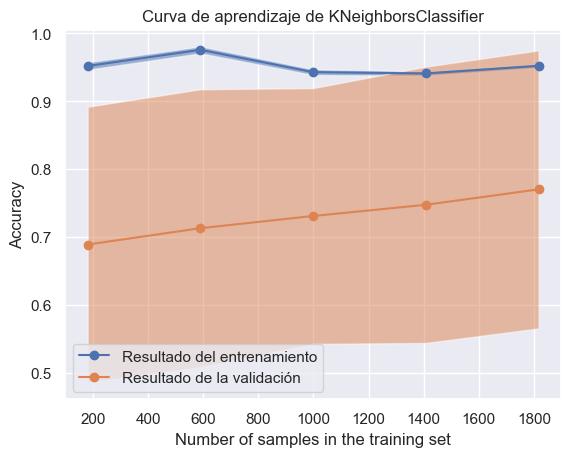


Modelo: DecisionTreeClassifier
Mejores parámetros:  {'criterion': 'log_loss', 'max_depth': 50, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'splitter': 'random'}
Mejor resultado:  0.8416963508253769


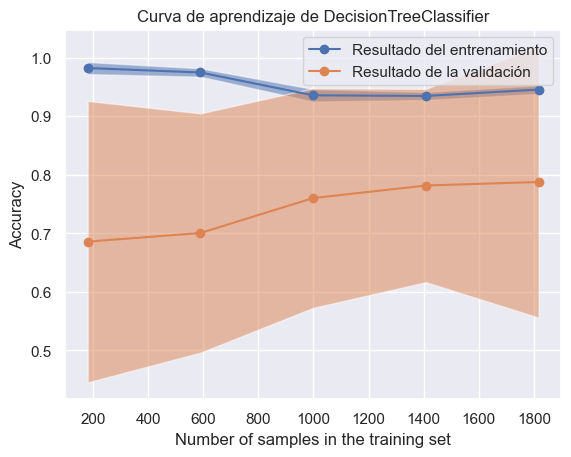


Modelo: GaussianNB
Mejores parámetros:  {'var_smoothing': 3.853528593710527e-06}
Mejor resultado:  0.6914872660826044


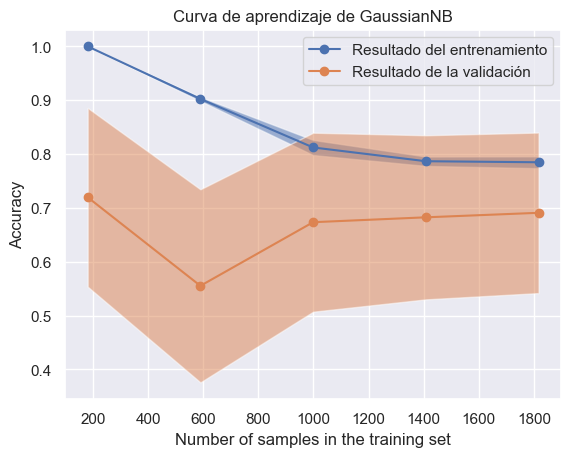


Modelo: SVC
Mejores parámetros:  {'C': 0.1, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Mejor resultado:  0.8339482513095188


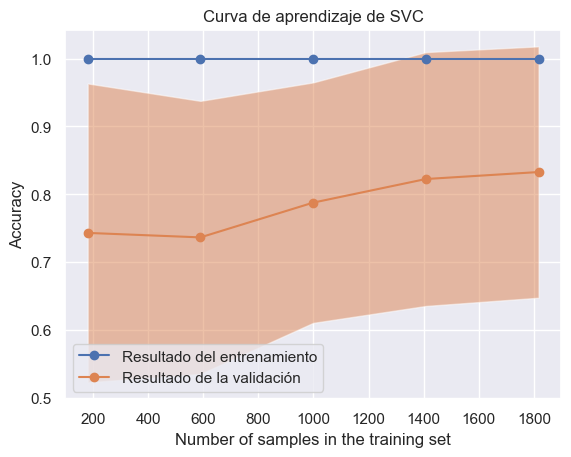


Modelo: RandomForestClassifier
Mejores parámetros:  {'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Mejor resultado:  0.8709789321749172


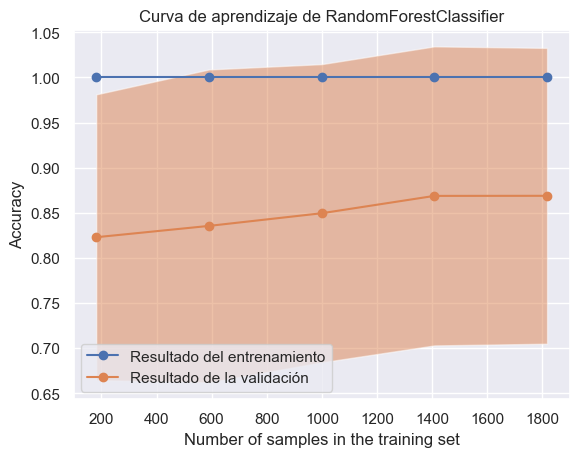

In [13]:
def aplicar_hiperparametrizacion(X, y):
    logo = LeaveOneGroupOut()
    gs_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=logo, scoring='accuracy', n_jobs=-1)
    gs_dtree = GridSearchCV(DecisionTreeClassifier(), param_grid_dtree, cv=logo, scoring='accuracy', n_jobs=-1)
    gs_nb = GridSearchCV(GaussianNB(), param_grid_nb, cv=logo, scoring='accuracy', n_jobs=-1)
    gs_svm = GridSearchCV(SVC(), param_grid_svm, cv=logo, scoring='accuracy', n_jobs=-1)
    gs_rf = RandomizedSearchCV(RandomForestClassifier(), param_grid_rf, cv=logo, scoring='accuracy', n_jobs=-1)

    subject_ids = X['SubjectID']
    
    modelos = [gs_knn, gs_dtree, gs_nb, gs_svm, gs_rf]


    best_models = []
    for modelo in modelos:
        modelo.fit(X, y, groups=subject_ids)
        best_modelo = modelo.best_estimator_
        print(f"\nModelo: {modelo.estimator.__class__.__name__}") 
        print("Mejores parámetros: ", modelo.best_params_)
        print("Mejor resultado: ", modelo.best_score_)
        best_models.append(best_modelo)
        LearningCurveDisplay.from_estimator(best_modelo, 
                                            X=X,
                                            y=y,
                                            groups=subject_ids,
                                            cv=logo,
                                            score_type="both",
                                            n_jobs=4,
                                            line_kw={"marker": "o"},
                                            std_display_style="fill_between",
                                            score_name="Accuracy"
                                        )
         
        plt.legend(["Resultado del entrenamiento", "Resultado de la validación"])
        plt.title(f"Curva de aprendizaje de {modelo.estimator.__class__.__name__}")
        plt.show()

    return best_models, gs_rf
    
plt.figure(figsize=(6,4))

best_models, gs_rf = aplicar_hiperparametrizacion(train_X, train_y)

In [14]:
test_models(best_models, test_X, test_y, test_result, 'Hiperparametrización (H)')


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.76      0.93      0.84        58
           1       0.81      0.83      0.82        66
           2       0.63      0.65      0.64        95
           3       0.71      0.74      0.72        69
           4       0.83      0.46      0.59        94
           5       0.60      0.69      0.64        55
           6       0.94      0.86      0.90        58
           7       0.66      0.90      0.76        72
           8       0.74      0.67      0.71        95

    accuracy                           0.73       662
   macro avg       0.74      0.75      0.74       662
weighted avg       0.74      0.73      0.72       662


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.75      0.91      0.82        58
           1       0.88      0.65      0.75        66
           2       0.62      0.74      0.67        95
           3    

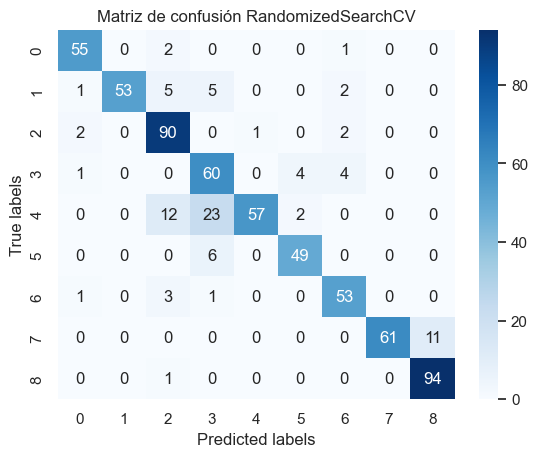

In [15]:
plot_confusion_matrix(gs_rf, test_X, test_y)

## 4. Feature Selection

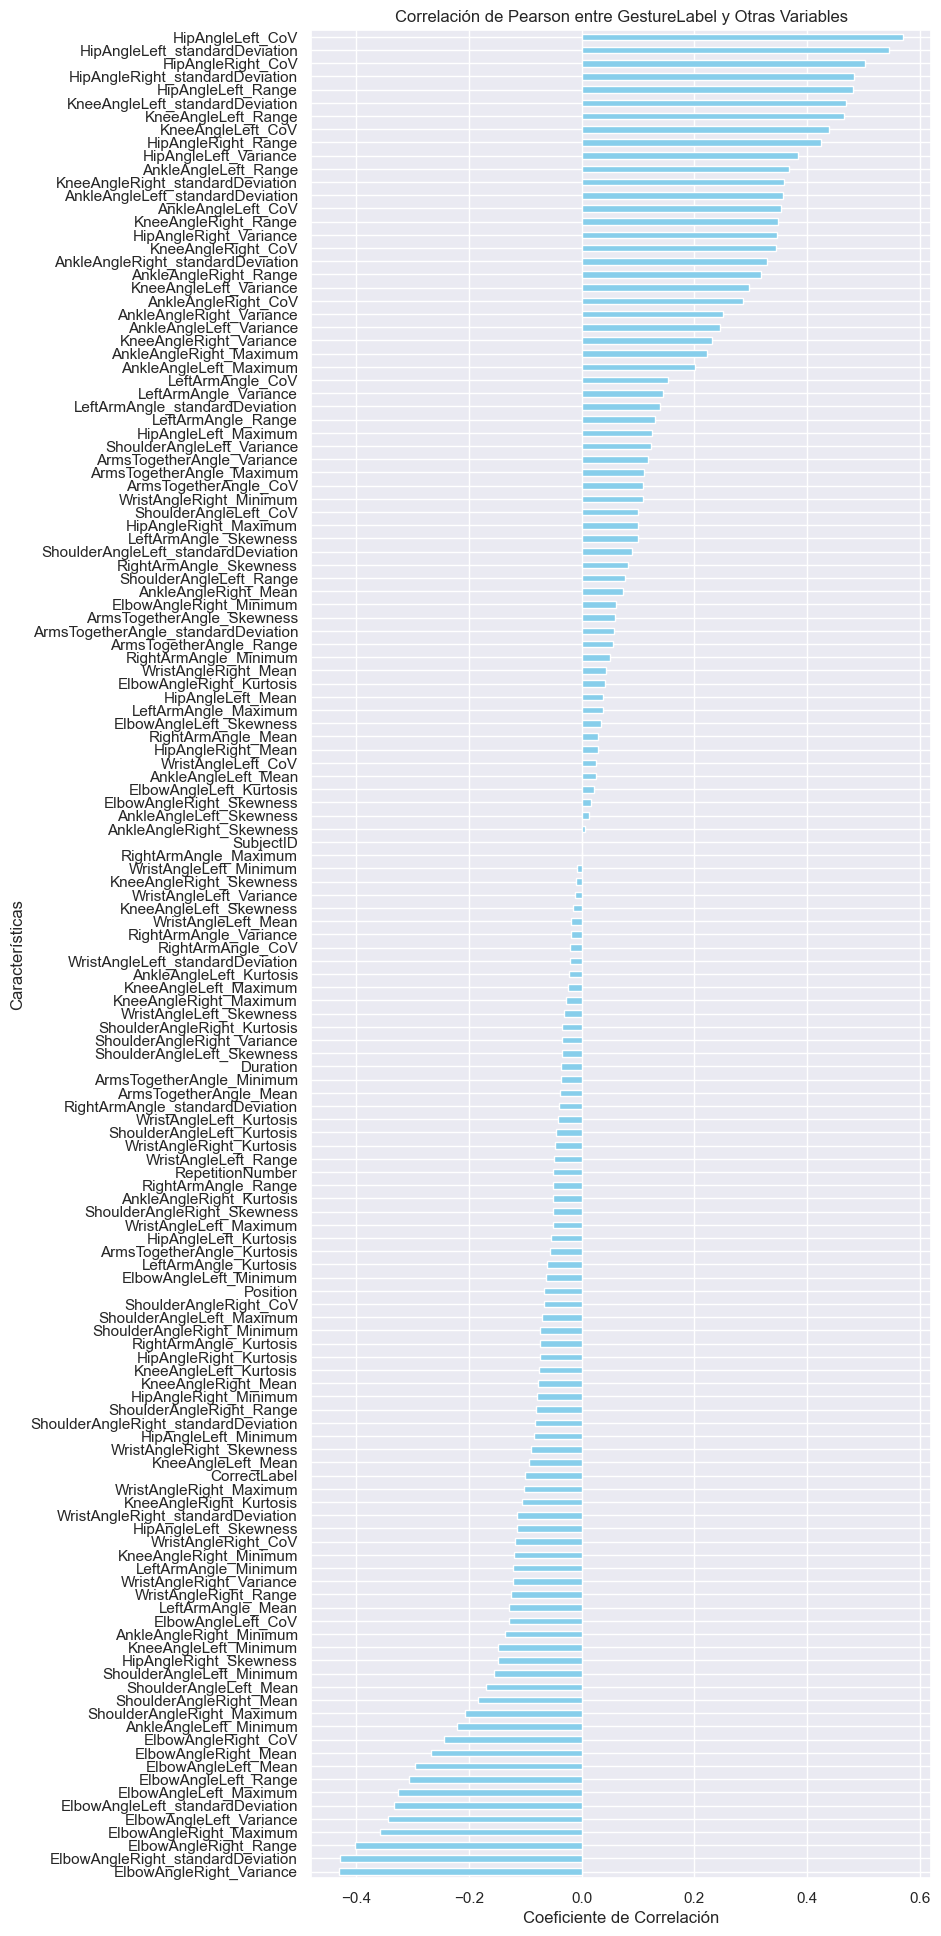

In [16]:
# lineal o no lineal
# correlacion de pearson

correlation_with_target = df.corr()['GestureLabel'].drop('GestureLabel')

sorted_correlations = correlation_with_target.sort_values()

# Crear el gráfico de barras
plt.figure(figsize=(8, 24))
sorted_correlations.plot(kind='barh', color='skyblue')
plt.title('Correlación de Pearson entre GestureLabel y Otras Variables')
plt.xlabel('Coeficiente de Correlación')
plt.ylabel('Características')
plt.show()

### 4.1 SelectKBest

In [17]:
subject_id = train_X['SubjectID']


# Definimos feature Selection K=50 (selecciona entonces las 50 variables que considere mas importantes)
feature_selection = SelectKBest(k=50)#, score_func=mutual_info_classif)

# Fit Feature Selection (entrena y hace una tranfosmada)
selected_features = feature_selection.fit_transform(train_X.drop(columns=['SubjectID']), train_y)

# Selecionamos las características mas relevantes para nuestro problema
selected = feature_selection.get_support(indices=True)

print(train_X.columns[selected])

# Reduce train_X to the selected features with .transform(X)
#creamos un data frame vacio para hacer una tabla donde esten 
# las variables con la trsnformada de la X.
# esto elimina las variales que no nos intersan.


X_fs = pd.DataFrame(selected_features,
                 columns=train_X.drop(columns=['SubjectID']).columns[selected])

X_fs['SubjectID'] = subject_id.values


Index(['Duration', 'HipAngleLeft_standardDeviation',
       'RightArmAngle_standardDeviation', 'KneeAngleRight_standardDeviation',
       'ElbowAngleRight_standardDeviation', 'LeftArmAngle_standardDeviation',
       'WristAngleLeft_standardDeviation', 'WristAngleRight_standardDeviation',
       'ShoulderAngleLeft_standardDeviation',
       'HipAngleRight_standardDeviation', 'KneeAngleRight_Maximum',
       'LeftArmAngle_Maximum', 'WristAngleLeft_Maximum',
       'WristAngleRight_Maximum', 'HipAngleLeft_Minimum',
       'ElbowAngleRight_Minimum', 'LeftArmAngle_Minimum',
       'WristAngleRight_Minimum', 'HipAngleRight_Minimum', 'HipAngleLeft_Mean',
       'ElbowAngleRight_Mean', 'LeftArmAngle_Mean', 'WristAngleRight_Mean',
       'HipAngleRight_Mean', 'AnkleAngleRight_Mean', 'HipAngleLeft_Range',
       'RightArmAngle_Range', 'KneeAngleRight_Range', 'ElbowAngleRight_Range',
       'LeftArmAngle_Range', 'WristAngleLeft_Range', 'WristAngleRight_Range',
       'HipAngleRight_Range', 'HipAn

### 4.2 Entrenar con las variables sleccionadas

In [18]:
# creación de los modelos
knn_fs = KNeighborsClassifier() # K-Neighbors classifier
dtree_fs = DecisionTreeClassifier() # Decision tree
nb_fs = GaussianNB() # Naive Bayes
svm_fs = SVC() # Suport Vector Machine
rf_fs = RandomForestClassifier()  # Random Forest

models_fs = [knn_fs, dtree_fs, nb_fs, svm_fs, rf_fs]

logo = LeaveOneGroupOut()

for modelo in models_fs:
        print(f"\nModelo: {modelo.__class__.__name__}")
        modelo.fit(X_fs, train_y)
        scores = cross_val_score(modelo, X_fs, train_y, groups=X_fs['SubjectID'],  scoring='accuracy', cv=logo)
        print("%0.2f accuracy con una derivación estandar de %0.2f" % (scores.mean(), scores.std()))


Modelo: KNeighborsClassifier
0.72 accuracy con una derivación estandar de 0.18

Modelo: DecisionTreeClassifier
0.82 accuracy con una derivación estandar de 0.18

Modelo: GaussianNB
0.70 accuracy con una derivación estandar de 0.15

Modelo: SVC
0.65 accuracy con una derivación estandar de 0.16

Modelo: RandomForestClassifier
0.87 accuracy con una derivación estandar de 0.16


In [19]:
test_subject_id = test_X['SubjectID']


selected_features_test = feature_selection.transform(test_X.drop(columns=['SubjectID']))

X_fs_test = pd.DataFrame(selected_features_test, columns=test_X.drop(columns=['SubjectID']).columns[selected])

X_fs_test['SubjectID'] = test_subject_id.values

test_models(models_fs, X_fs_test, test_y, test_result, 'Selección de variables (FS)')


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.74      0.97      0.84        58
           1       0.82      0.88      0.85        66
           2       0.67      0.80      0.73        95
           3       0.65      0.64      0.64        69
           4       0.49      0.39      0.44        94
           5       0.55      0.73      0.62        55
           6       0.96      0.86      0.91        58
           7       0.82      0.75      0.78        72
           8       0.79      0.56      0.65        95

    accuracy                           0.71       662
   macro avg       0.72      0.73      0.72       662
weighted avg       0.71      0.71      0.70       662


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.68      0.90      0.78        58
           1       0.90      0.80      0.85        66
           2       0.80      0.77      0.78        95
           3    

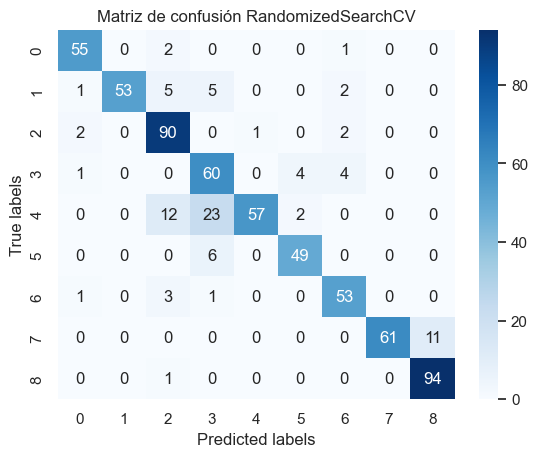

In [20]:
plot_confusion_matrix(gs_rf, test_X, test_y)

In [21]:
for modelo in best_models:
    modelo.fit(X_fs, train_y)
test_models(best_models, X_fs_test, test_y, test_result, 'H + Fs')


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.77      0.98      0.86        58
           1       0.81      0.88      0.84        66
           2       0.72      0.84      0.78        95
           3       0.74      0.74      0.74        69
           4       0.69      0.47      0.56        94
           5       0.57      0.75      0.65        55
           6       0.96      0.86      0.91        58
           7       0.88      0.85      0.87        72
           8       0.90      0.75      0.82        95

    accuracy                           0.77       662
   macro avg       0.78      0.79      0.78       662
weighted avg       0.78      0.77      0.77       662


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.71      0.90      0.79        58
           1       0.94      0.68      0.79        66
           2       0.80      0.78      0.79        95
           3    

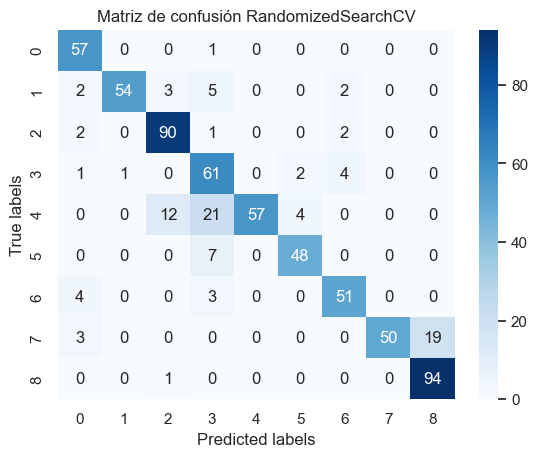

In [22]:
plot_confusion_matrix(gs_rf, X_fs_test, test_y)

### 4.3 Recursive feature elimination

In [23]:
dtree_rfe = DecisionTreeClassifier() # Decision tree
rf_rfe = RandomForestClassifier(n_estimators = 5)  # Random Forest

models_with_coef = [dtree_rfe, rf_rfe]


Modelo: DecisionTreeClassifier
Número óptimo de características: 14
['RepetitionNumber' 'RightArmAngle_standardDeviation'
 'ElbowAngleLeft_standardDeviation' 'HipAngleLeft_Maximum'
 'ElbowAngleRight_Maximum' 'ShoulderAngleRight_Maximum'
 'ShoulderAngleLeft_Maximum' 'RightArmAngle_Mean' 'HipAngleRight_Mean'
 'KneeAngleLeft_Range' 'KneeAngleRight_Range' 'LeftArmAngle_Range'
 'WristAngleRight_Variance' 'HipAngleLeft_CoV']
0.7341389728096677


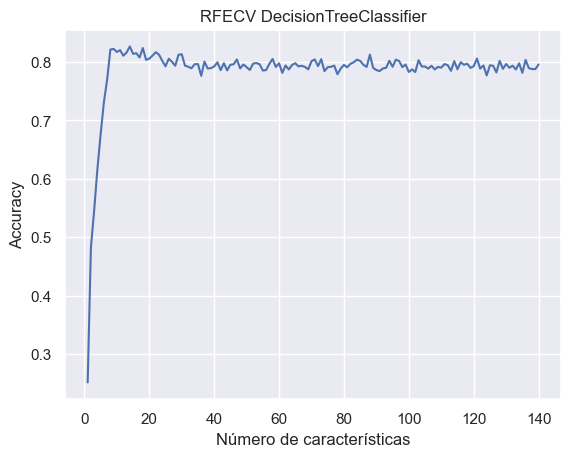


Modelo: RandomForestClassifier
Número óptimo de características: 30
['HipAngleLeft_standardDeviation' 'RightArmAngle_standardDeviation'
 'KneeAngleLeft_standardDeviation' 'ElbowAngleRight_standardDeviation'
 'ShoulderAngleRight_standardDeviation'
 'ArmsTogetherAngle_standardDeviation' 'HipAngleLeft_Maximum'
 'ElbowAngleRight_Maximum' 'ShoulderAngleRight_Maximum'
 'ElbowAngleLeft_Maximum' 'WristAngleRight_Maximum'
 'ShoulderAngleLeft_Maximum' 'RightArmAngle_Minimum'
 'LeftArmAngle_Minimum' 'RightArmAngle_Mean' 'LeftArmAngle_Mean'
 'ShoulderAngleLeft_Mean' 'HipAngleRight_Mean' 'KneeAngleLeft_Range'
 'KneeAngleRight_Range' 'ElbowAngleRight_Range' 'ShoulderAngleRight_Range'
 'ElbowAngleLeft_Range' 'ShoulderAngleLeft_Range' 'HipAngleRight_Range'
 'ArmsTogetherAngle_Range' 'LeftArmAngle_Variance'
 'ShoulderAngleRight_Variance' 'HipAngleLeft_CoV' 'LeftArmAngle_CoV']
0.8323262839879154


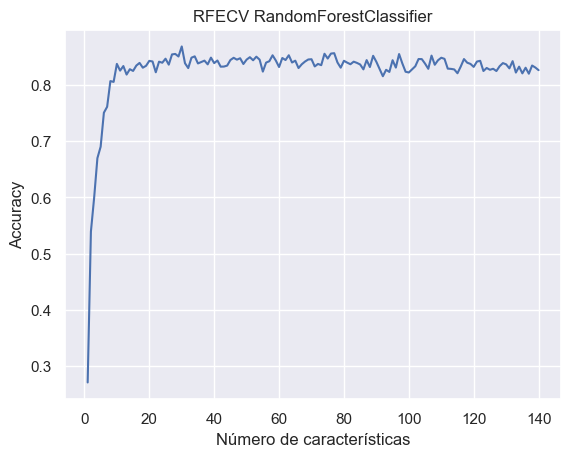

In [24]:
def seleccion_variables(models, X, y, Xt, yt):
    for model in models:
        rfecv = RFECV(
             estimator=model,
            scoring="accuracy",
            cv = LeaveOneGroupOut(),
            n_jobs=-1 # Number of cores to run in parallel while fitting across folds. 
        )
        rfecv.fit(X, y, groups=X['SubjectID'])
        print(f"\nModelo: {rfecv.estimator.__class__.__name__}") 
        print(f"Número óptimo de características: {rfecv.n_features_}")
        selected = rfecv.get_feature_names_out()
        print(selected)
        print(rfecv.score(Xt, yt))
        cv_results = pd.DataFrame(rfecv.cv_results_)
        plt.title(f"RFECV {rfecv.estimator.__class__.__name__}")
        plt.xlabel("Número de características")
        plt.ylabel("Accuracy")
        plt.plot(range(1, len(cv_results['mean_test_score']) + 1), cv_results['mean_test_score'])
        plt.show()

seleccion_variables(models_with_coef, train_X, train_y, test_X, test_y)

# Evaluación modelos

In [25]:
test_result

,Clasificadores,Modelos,Hiperparametrización (H),Selección de variables (FS),H + Fs
0,K-Neighbors,0.688613,0.723041,0.701863,0.771565
1,Decision tree,0.736535,0.738639,0.789524,0.763647
2,Naive Bayes,0.678895,0.674416,0.734144,0.736108
3,Suport Vector Machine,0.717582,0.785543,0.583022,0.824445
4,Random Forest,0.857741,0.863498,0.851337,0.847443


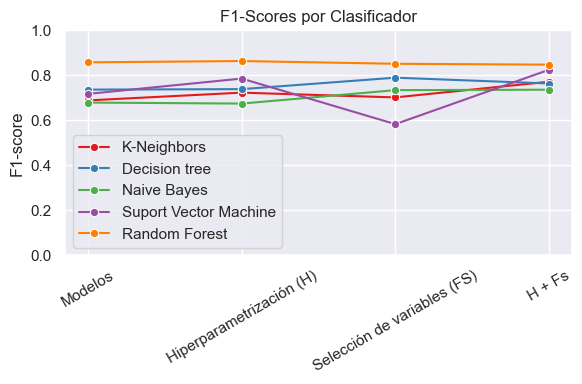

In [26]:
# Melt the dataframe to transform it into long format
df_melted = pd.melt(test_result, id_vars=['Clasificadores'], value_vars=['Modelos', 'Hiperparametrización (H)', 'Selección de variables (FS)', 'H + Fs'],
                    var_name='score_type', value_name='score')

# Plot using seaborn
plt.figure(figsize=(6, 4))
ax = sns.lineplot(x='score_type', y='score', hue='Clasificadores', data=df_melted, marker='o', palette='Set1')
# Set labels and title
ax.set(xlabel=None)
plt.ylabel('F1-score')
plt.title('F1-Scores por Clasificador')
plt.ylim(0,1)
plt.legend(loc='lower left')
# Display the plot
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()